# Final Project

In [1]:
!pip install statsmodels

In [2]:
# Imports

import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [3]:
# Connection

DB_USER = "mfre521d_user"
DB_PASSWORD = "mfre521d_user_pw"
DB_HOST = "localhost"
DB_PORT = "3306"
DB_NAME = "mfre521d"

connection_string = (
    f"mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)
engine = create_engine(connection_string)

print("Connection established!")

Connection established!


## Research Question 1: Identifying Climate-Vulnerable Crops

Policy makers need to know which staple crops are most threatened by climate change so they can prioritize breeding programs and adaptation investments. To address this, we use our integrated dataset to assess the threat that climate change poses to staple crops, such as wheat, rice, maize, and soybeans. We quantify the relationship between climate variables and crop yields, integrating control variables, such as irrigation, fertilizer, and economic development. We then rank crop vulnerability to demonstrate a clear overview of climate change threat. 

In [4]:
# pulling the integrated dataset

df_integrated = pd.read_sql("SELECT * FROM crop_weather_integrated;", engine)
df_integrated.shape
df_integrated.head()

,country_id,country_name,iso3_code,region,income_group,year,crop_id,area_harvested_ha,production_tonnes,yield_kg_ha,...,n_days,temperature_mean_yr,temperature_max_yr,temperature_min_yr,precipitation_yr,rain_yr,evapotranspiration_yr,gdd_yr,precipitation_sd_yr,extreme_temp_days_yr
0,1,China,CHN,East Asia,Upper middle income,2015,1,3462170.0,20981200.0,6060.13,...,365,9.363562,34.2,-13.1,487.899999,409.399999,1162.74,1380.900003,3.647763,141.0
1,1,China,CHN,East Asia,Upper middle income,2015,2,4480770.0,NaN,7985.39,...,365,9.363562,34.2,-13.1,487.899999,409.399999,1162.74,1380.900003,3.647763,141.0
2,1,China,CHN,East Asia,Upper middle income,2015,3,4853030.0,23410200.0,4823.83,...,365,9.363562,34.2,-13.1,487.899999,409.399999,1162.74,1380.900003,3.647763,141.0
3,1,China,CHN,East Asia,Upper middle income,2015,4,4066070.0,29467400.0,7247.14,...,365,9.363562,34.2,-13.1,487.899999,409.399999,1162.74,1380.900003,3.647763,141.0
4,1,China,CHN,East Asia,Upper middle income,2016,1,1859830.0,16251000.0,8737.91,...,366,9.532514,33.4,-18.5,412.800001,368.200001,1184.06,1506.799999,2.814997,135.0


### Data checks

In [5]:
# checking number of observations by crop_id column
df_integrated["crop_id"].value_counts().sort_index()

crop_id
1    306
2    258
3    236
4    306
Name: count, dtype: int64

In [6]:
# bringing in crop information (crop_id, crop_name)
crop_lookup = pd.read_sql("SELECT crop_id, crop_name FROM crops;", engine)
crop_lookup

,crop_id,crop_name
0,1,Maize
1,2,Rice
2,3,Soybeans
3,4,Wheat


In [7]:
# merging dataframes to assign crop_name
df_integrated = df_integrated.merge(crop_lookup, on="crop_id", how="left")
df_integrated["crop_name"].value_counts()

crop_name
Maize       306
Wheat       306
Rice        258
Soybeans    236
Name: count, dtype: int64

In [8]:
df_integrated.head()

,country_id,country_name,iso3_code,region,income_group,year,crop_id,area_harvested_ha,production_tonnes,yield_kg_ha,...,temperature_mean_yr,temperature_max_yr,temperature_min_yr,precipitation_yr,rain_yr,evapotranspiration_yr,gdd_yr,precipitation_sd_yr,extreme_temp_days_yr,crop_name
0,1,China,CHN,East Asia,Upper middle income,2015,1,3462170.0,20981200.0,6060.13,...,9.363562,34.2,-13.1,487.899999,409.399999,1162.74,1380.900003,3.647763,141.0,Maize
1,1,China,CHN,East Asia,Upper middle income,2015,2,4480770.0,NaN,7985.39,...,9.363562,34.2,-13.1,487.899999,409.399999,1162.74,1380.900003,3.647763,141.0,Rice
2,1,China,CHN,East Asia,Upper middle income,2015,3,4853030.0,23410200.0,4823.83,...,9.363562,34.2,-13.1,487.899999,409.399999,1162.74,1380.900003,3.647763,141.0,Soybeans
3,1,China,CHN,East Asia,Upper middle income,2015,4,4066070.0,29467400.0,7247.14,...,9.363562,34.2,-13.1,487.899999,409.399999,1162.74,1380.900003,3.647763,141.0,Wheat
4,1,China,CHN,East Asia,Upper middle income,2016,1,1859830.0,16251000.0,8737.91,...,9.532514,33.4,-18.5,412.800001,368.200001,1184.06,1506.799999,2.814997,135.0,Maize


In [9]:
# checking missing data for yield_kg_ha, temperature_mean_yr & precipitation_yr
key_cols = ["yield_kg_ha", "temperature_mean_yr", "precipitation_yr"]
df_integrated[key_cols].isna().mean().sort_values(ascending=False)

yield_kg_ha            0.023508
temperature_mean_yr    0.000000
precipitation_yr       0.000000
dtype: float64

In [10]:
df_integrated[key_cols].isna().sum()

yield_kg_ha            26
temperature_mean_yr     0
precipitation_yr        0
dtype: int64

There are no missing data for temperature_mean_yr and precipitation_yr; however, there are 2.35% (26 observations) of data missing for yield_kg_ha.

### Creating RQ1 dataset

In [11]:
# creating RQ1 dataset
df_rq1 = df_integrated.copy()
df_rq1.shape

(1106, 24)

Dropping NA values from yield_kg_ha for future analysis.

In [12]:
# creating model data (no NAs)
df_rq1_model = df_rq1.dropna(subset=["yield_kg_ha"]).copy()
df_rq1_model.shape

(1080, 24)

In [13]:
# log transforming crop yield
df_rq1_model = df_rq1_model[df_rq1_model["yield_kg_ha"] > 0].copy()
df_rq1_model["ln_yield"] = np.log(df_rq1_model["yield_kg_ha"])

In [14]:
df_rq1_model.shape
df_rq1_model.head()

,country_id,country_name,iso3_code,region,income_group,year,crop_id,area_harvested_ha,production_tonnes,yield_kg_ha,...,temperature_max_yr,temperature_min_yr,precipitation_yr,rain_yr,evapotranspiration_yr,gdd_yr,precipitation_sd_yr,extreme_temp_days_yr,crop_name,ln_yield
0,1,China,CHN,East Asia,Upper middle income,2015,1,3462170.0,20981200.0,6060.13,...,34.2,-13.1,487.899999,409.399999,1162.74,1380.900003,3.647763,141.0,Maize,8.709487
1,1,China,CHN,East Asia,Upper middle income,2015,2,4480770.0,NaN,7985.39,...,34.2,-13.1,487.899999,409.399999,1162.74,1380.900003,3.647763,141.0,Rice,8.985369
2,1,China,CHN,East Asia,Upper middle income,2015,3,4853030.0,23410200.0,4823.83,...,34.2,-13.1,487.899999,409.399999,1162.74,1380.900003,3.647763,141.0,Soybeans,8.481323
3,1,China,CHN,East Asia,Upper middle income,2015,4,4066070.0,29467400.0,7247.14,...,34.2,-13.1,487.899999,409.399999,1162.74,1380.900003,3.647763,141.0,Wheat,8.888362
4,1,China,CHN,East Asia,Upper middle income,2016,1,1859830.0,16251000.0,8737.91,...,33.4,-18.5,412.800001,368.200001,1184.06,1506.799999,2.814997,135.0,Maize,9.075426


In [15]:
# checking crop yield data
df_rq1_model.groupby("crop_name")["yield_kg_ha"].describe()[
    ["count", "mean", "std", "min", "max"]
]

,count,mean,std,min,max
crop_name,,,,,
Maize,296.0,8865.059257,2857.152788,3105.75,17525.40
Rice,255.0,6934.460824,1918.290927,3375.41,12128.60
Soybeans,231.0,4311.928615,1342.530582,1266.20,8147.15
Wheat,298.0,5684.142148,1679.665100,2263.06,10059.60


In [16]:
pd.read_sql("SHOW TABLES;", engine)

,Tables_in_mfre521d
0,AirQuality_2
1,air_quality_readings
2,annual_weather
3,annual_weather_quality_checks
4,climate_agriculture_analysis
5,countries
6,country_name_mapping
7,crop_production
8,crop_weather_integrated
9,crops


In [17]:
# Proxy for temperature variability proxy: temp_sd_daily_mean_yr
# from daily_weather, creating temp_sd_daily_mean_yr variable to measure temperature variation (how much temperature fluctuates day-to-day within the year)

sql_temp_var = """
SELECT
    iso3_code,
    year,
    STDDEV_SAMP(temperature_mean) AS temp_sd_daily_mean_yr
FROM daily_weather
GROUP BY iso3_code, year;
"""
df_temp_var = pd.read_sql(sql_temp_var, engine)
df_temp_var.head()

,iso3_code,year,temp_sd_daily_mean_yr
0,ARG,2015,6.229465
1,ARG,2016,6.729484
2,ARG,2017,6.186895
3,ARG,2018,6.853990
4,ARG,2019,6.456126


### Climate variables

#### Temperature variability

Our `daily_weather` table provides high-frequency daily weather data. We use this to calculate the sample standard deviation of the daily mean temperatures in each year for each country. This temp_sd_daily_mean_yr captures how much temperature fluctuates day-to-day within the year, i.e., the spread around the yearly mean of daily temperatures. This is better than simply using yearly temperature variation, which could mainly be picking up on seasonal variation and extreme temperatures. We also look at extreme_temp_days_yr, which captures the frequency of extreme heat exposure.

#### Precipitation and water availability variability

To assess precipitation variability we look at the standard deviation of precipitation within that year. Additionally, we look at water stress, by constructing a "water_deficit_yr" variable that is evapotranspiration_yr minus precipitation_yr, which measures a net moisture deficit. Water deficit is a level measure of annual water stress (evapotranspiration demand minus precipitation), while precipitation_sd_yr captures within-year variability in rainfall.

In [18]:
# adding newly created temp_sd_daily_mean_yr variable to the modeling dataframe

df_rq1_model = df_rq1_model.merge(df_temp_var, on=["iso3_code", "year"], how="left")
df_rq1_model[["temp_sd_daily_mean_yr"]].isna().mean()

temp_sd_daily_mean_yr    0.0
dtype: float64

In [19]:
# -----------------------------
# RQ1 variables creation
# -----------------------------

# Temperature variability: using
# within-year SD of DAILY mean temperature (computed from daily_weather (daily table), then aggregated to country-year SD) already merged
# extreme_temp_days_yr already in the data

# Water stress proxy: water deficit (higher = more deficit = more stress)
df_rq1_model["water_deficit_yr"] = (
    df_rq1_model["evapotranspiration_yr"] - df_rq1_model["precipitation_yr"]
)

# modeling variables
model_vars = [
    "ln_yield",
    "temperature_mean_yr",
    "precipitation_yr",
    "precipitation_sd_yr",
    "extreme_temp_days_yr",
    "temp_sd_daily_mean_yr",
    "water_deficit_yr",
    "fertilizer_use_kg_ha",
    "irrigation_pct",
]

# missingness check
missing = df_rq1_model[model_vars].isna().mean().sort_values(ascending=False)
missing

irrigation_pct           0.030556
fertilizer_use_kg_ha     0.029630
ln_yield                 0.000000
temperature_mean_yr      0.000000
precipitation_yr         0.000000
precipitation_sd_yr      0.000000
extreme_temp_days_yr     0.000000
temp_sd_daily_mean_yr    0.000000
water_deficit_yr         0.000000
dtype: float64

Given some missing values for irrigation_pct and fertilizer_use_kg_ha, these were dropped for modeling.

In [20]:
# Final modeling dataset for RQ1: drop rows missing any model vars

df_rq1_analysis = df_rq1_model.dropna(subset=model_vars).copy()

print("Rows before:", len(df_rq1_model))
print("Rows after :", len(df_rq1_analysis))
print("Dropped    :", len(df_rq1_model) - len(df_rq1_analysis))

Rows before: 1080
Rows after : 1017
Dropped    : 63


### Estimating the main model

We estimate crop-specific panel regressions of log yield on climate levels and climate variability measures, controlling for irrigation and fertilizer use and including country and year fixed effects. We use HC1 robust standard errors.

In [21]:
# running a regression per crop
# dependent variable: ln_yield
# key predictors: climate + controls
# country & year FEs included to control for time-invariant country specifics + global shocks/trends

formula = """
ln_yield
  ~ temperature_mean_yr
  + precipitation_yr
  + precipitation_sd_yr
  + extreme_temp_days_yr
  + temp_sd_daily_mean_yr
  + water_deficit_yr
  + fertilizer_use_kg_ha
  + irrigation_pct
  + C(iso3_code)
  + C(year)
"""


def run_crop_reg(df, crop):
    d = df[df["crop_name"] == crop].copy()
    model = smf.ols(formula, data=d).fit(cov_type="HC1")  # robust SEs
    return model, len(d)


crops = sorted(df_rq1_analysis["crop_name"].unique())
results = []

for c in crops:
    m, n = run_crop_reg(df_rq1_analysis, c)
    for var in [
        "temperature_mean_yr",
        "temp_sd_daily_mean_yr",
        "extreme_temp_days_yr",
        "precipitation_yr",
        "precipitation_sd_yr",
        "water_deficit_yr",
    ]:
        results.append(
            {
                "crop": c,
                "n": n,
                "variable": var,
                "coef": m.params.get(var),
                "se_robust": m.bse.get(var),
                "pvalue": m.pvalues.get(var),
                "r2": m.rsquared,
            }
        )

# extracting for each crop regression only the coefficient results for the climate variables we care about
rq1_coef_table = pd.DataFrame(results)
rq1_coef_table

,crop,n,variable,coef,se_robust,pvalue,r2
0,Maize,282,temperature_mean_yr,0.008568,0.033558,0.798483,0.683220
1,Maize,282,temp_sd_daily_mean_yr,0.043312,0.035507,0.222536,0.683220
2,Maize,282,extreme_temp_days_yr,-0.002643,0.001157,0.022388,0.683220
3,Maize,282,precipitation_yr,-0.000057,0.000341,0.867374,0.683220
4,Maize,282,precipitation_sd_yr,0.011914,0.011738,0.310084,0.683220
5,Maize,282,water_deficit_yr,0.000036,0.000318,0.910297,0.683220
6,Rice,238,temperature_mean_yr,-0.013929,0.021222,0.511600,0.875724
7,Rice,238,temp_sd_daily_mean_yr,-0.039802,0.023617,0.091930,0.875724
8,Rice,238,extreme_temp_days_yr,0.001826,0.000641,0.004393,0.875724
9,Rice,238,precipitation_yr,-0.000003,0.000193,0.988232,0.875724


In [22]:
# for each climate variable, list crops ordered by statistical significance (lowest p-value first)

rq1_coef_table.sort_values(["variable", "pvalue"]).groupby("variable").head(4)

,crop,n,variable,coef,se_robust,pvalue,r2
8,Rice,238,extreme_temp_days_yr,0.001826,0.000641,0.004393,0.875724
2,Maize,282,extreme_temp_days_yr,-0.002643,0.001157,0.022388,0.683220
14,Soybeans,215,extreme_temp_days_yr,-0.002038,0.001194,0.087802,0.769526
20,Wheat,282,extreme_temp_days_yr,-0.001421,0.000976,0.145454,0.758822
16,Soybeans,215,precipitation_sd_yr,-0.015549,0.012416,0.210448,0.769526
4,Maize,282,precipitation_sd_yr,0.011914,0.011738,0.310084,0.683220
22,Wheat,282,precipitation_sd_yr,-0.010306,0.011728,0.379532,0.758822
10,Rice,238,precipitation_sd_yr,-0.005097,0.007085,0.471841,0.875724
21,Wheat,282,precipitation_yr,0.000228,0.000270,0.397851,0.758822
15,Soybeans,215,precipitation_yr,0.000159,0.000366,0.662962,0.769526


For RQ1, we estimate crop-specific panel regressions of log yield (kg/ha) on annual climate conditions: mean temperature, total precipitation, precipitation variability (annual SD), temperature variability (within-year SD of daily mean temperature), extreme heat exposure (extreme temperature days), and a water-stress proxy (annual water deficit = evapotranspiration − precipitation). We include country and year fixed effects and use heteroskedasticity-robust (HC1) standard errors.

In the crop-by-crop results, the strongest statistical signal appears for extreme heat days, with rice (p≈0.004) and maize (p≈0.022) showing statistically significant associations (with opposite signs in our specification). Evidence for temperature variability is weaker: only rice shows a negative, marginally significant association at the 10% level (p≈0.091). For precipitation levels, precipitation variability, and water deficit, we do not observe statistically significant associations at conventional levels in this sample.

For the variables with the strongest statistical signal, the coefficient signs indicate direction: maize yields decline with additional extreme heat days (negative coefficient, p≈0.022), while rice shows a positive association with extreme heat days in this specification (p≈0.004). Rice also shows a negative, marginal association with temperature variability (p≈0.091).

In general, coefficient signs should be interpreted with caution given the small crop set and coarse annual aggregations.

### Sensitivity Summary

In [ ]:
targets = [
    "extreme_temp_days_yr",
    "temperature_mean_yr",
    "precipitation_sd_yr",
    "water_deficit_yr",
]

sens_table = (
    rq1_coef_table[rq1_coef_table["variable"].isin(targets)]
    .assign(
        direction=lambda d: np.where(d["coef"] < 0, "negative", "positive"),
        sig_10=lambda d: d["pvalue"] < 0.10,
    )
    .sort_values(["variable", "coef"])
    .reset_index(drop=True)
)

sens_table

,crop,n,variable,coef,se_robust,pvalue,r2,direction,sig_10
0,Maize,282,extreme_temp_days_yr,-0.002643,0.001157,0.022388,0.683220,negative,True
1,Soybeans,215,extreme_temp_days_yr,-0.002038,0.001194,0.087802,0.769526,negative,True
2,Wheat,282,extreme_temp_days_yr,-0.001421,0.000976,0.145454,0.758822,negative,False
3,Rice,238,extreme_temp_days_yr,0.001826,0.000641,0.004393,0.875724,positive,True
4,Soybeans,215,precipitation_sd_yr,-0.015549,0.012416,0.210448,0.769526,negative,False
5,Wheat,282,precipitation_sd_yr,-0.010306,0.011728,0.379532,0.758822,negative,False
6,Rice,238,precipitation_sd_yr,-0.005097,0.007085,0.471841,0.875724,negative,False
7,Maize,282,precipitation_sd_yr,0.011914,0.011738,0.310084,0.683220,positive,False
8,Soybeans,215,temperature_mean_yr,-0.020185,0.034251,0.555647,0.769526,negative,False
9,Rice,238,temperature_mean_yr,-0.013929,0.021222,0.511600,0.875724,negative,False


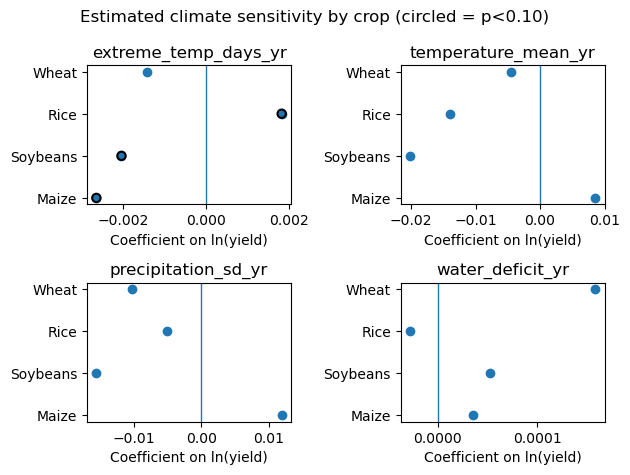

<Figure size 640x480 with 0 Axes>

In [24]:
# plotting climate sensitivity by crop

targets = [
    "extreme_temp_days_yr",
    "temperature_mean_yr",
    "precipitation_sd_yr",
    "water_deficit_yr",
]
df = sens_table[sens_table["variable"].isin(targets)].copy()

crop_order = ["Maize", "Soybeans", "Rice", "Wheat"]
df["crop"] = pd.Categorical(df["crop"], categories=crop_order, ordered=True)

vars_order = [v for v in targets if v in df["variable"].unique()]
ncols = 2
nrows = int(np.ceil(len(vars_order) / ncols))

fig = plt.figure()

for i, var in enumerate(vars_order, start=1):
    ax = fig.add_subplot(nrows, ncols, i)
    sub = df[df["variable"] == var].sort_values("crop")

    # all points
    ax.scatter(sub["coef"], sub["crop"])

    # circle the significant ones (p<0.10)
    if "sig_10" in sub.columns:
        sig = sub[sub["sig_10"]]
        ax.scatter(
            sig["coef"], sig["crop"], facecolors="none", edgecolors="k", linewidths=1.5
        )

    ax.axvline(0, linewidth=1)
    ax.set_title(var)
    ax.set_xlabel("Coefficient on ln(yield)")
    ax.set_ylabel("")

plt.suptitle("Estimated climate sensitivity by crop (circled = p<0.10)")
plt.tight_layout()
plt.show()

plt.savefig("fig1_climate_sensitivity.png", dpi=300, bbox_inches="tight")

This table summarizes crop-specific regression estimates for three key climate variables and labels each effect as positive/negative and statistically significant at the 10% level. Rows are sorted within each climate variable so the most negative (most yield-reducing) associations appear first.

## Vulnerability assessment

Climate stressors are measured on very different scales (e.g., extreme-heat days vs. temperature variability in °C), so comparing raw coefficients can be misleading. We therefore re-express each coefficient as the expected yield change from a typical increase in that stressor, defined as one standard deviation of its observed variation. This produces an interpretable metric: ‘yield impact of a typical shock’. A one–standard deviation change corresponds to a common, data-driven magnitude of fluctuation rather than an arbitrary one-unit change. This can then be summed across risk channels to rank crops by overall vulnerability. 

Because vulnerability is about yield losses, we focus on the yield-reducing portion of standardized effects. For each crop, we compute the predicted yield change from a one–standard deviation increase in each climate stressor and retain only negative (harmful) contributions. Summing these yield-loss contributions produces an overall vulnerability score that reflects both effect size and typical variability of each stressor.

### Defining the vulnerability index

We choose specific risk variables related to temperature and precipitation / water availability for our vulnerability index:

1. More extreme days → more heat stress
2. More temp variability → more instability
3. More precip variability → more erratic rainfall
4. More water deficit → drier / more water stress

For each risk variable, we compute the standard deviation to represent the “typical variation” in each risk variable for that crop’s dataset, which we use to compute a “typical shock effect” (1 SD change).

We associate this standard deviation to the coefficients obtained from our regressions to compute a standardised effect i.e., the change in ln(yield) from a 1 SD increase in each risk variable.

We then chose to define "vulnerability contribution" as only counting harmful effects to crop yield. If the std_effect is negative (i.e., when risk increases, yield decreases), this counts as contributing to vulnerability; if the std_effect is positive, we do not count this as "vulnerability" in the index.

We finally choose to give stronger vulnerability weighting when p-values are smaller, and thus more statistically significant. 

- if p = 0.01 → log(100) ≈ 4.6 (stronger weight)
- if p = 0.10 → log(10) ≈ 2.3
- if p = 0.50 → log(2) ≈ 0.69 (weak weight)


In [25]:
# =========================
# Vulnerability Index (Temp + Water)
# =========================

# choosing risk variables
risk_vars = [
    "extreme_temp_days_yr",  # heat extremes
    "temp_sd_daily_mean_yr",  # temperature variability
    "precipitation_sd_yr",  # precipitation variability
    "water_deficit_yr",  # water stress (evap - precip)
]

# computing the SD of each risk variable within each crop sample
sd_by_crop = (
    df_rq1_analysis.groupby("crop_name")[risk_vars]
    .std()
    .rename(columns=lambda c: f"sd_{c}")
    .reset_index()
)

# keeping only the regression results for the risk variables
coef_sub = rq1_coef_table[rq1_coef_table["variable"].isin(risk_vars)].copy()

# merging SDs onto coefficient table
coef_sub = coef_sub.merge(sd_by_crop, left_on="crop", right_on="crop_name", how="left")

# computing standardised effect: coef * SD(X) = change in ln(yield) for a 1 SD increase in X
coef_sub["std_effect"] = coef_sub["coef"] * coef_sub.apply(
    lambda r: r[f"sd_{r['variable']}"], axis=1
)

# vulnerability contribution: counting only harmful effects (negative std_effect)
coef_sub["vuln_component"] = np.maximum(0, -coef_sub["std_effect"])

# evidence weighting: higher weight attributed if p-value smaller
coef_sub["evidence_weight"] = np.log(1 / coef_sub["pvalue"].clip(lower=1e-6))

# weighted component
coef_sub["vuln_component_w"] = coef_sub["vuln_component"] * coef_sub["evidence_weight"]

# inspecting components
coef_sub_out = coef_sub[
    [
        "crop",
        "variable",
        "coef",
        "pvalue",
        "std_effect",
        "vuln_component",
        "evidence_weight",
        "vuln_component_w",
    ]
].sort_values(["crop", "variable"])

coef_sub_out

,crop,variable,coef,pvalue,std_effect,vuln_component,evidence_weight,vuln_component_w
1,Maize,extreme_temp_days_yr,-0.002643,0.022388,-0.160452,0.160452,3.799215,0.609590
2,Maize,precipitation_sd_yr,0.011914,0.310084,0.051867,0.000000,1.170911,0.000000
0,Maize,temp_sd_daily_mean_yr,0.043312,0.222536,0.149791,0.000000,1.502664,0.000000
3,Maize,water_deficit_yr,0.000036,0.910297,0.049040,0.000000,0.093985,0.000000
5,Rice,extreme_temp_days_yr,0.001826,0.004393,0.101258,0.000000,5.427779,0.000000
6,Rice,precipitation_sd_yr,-0.005097,0.471841,-0.023030,0.023030,0.751114,0.017298
4,Rice,temp_sd_daily_mean_yr,-0.039802,0.091930,-0.123553,0.123553,2.386730,0.294888
7,Rice,water_deficit_yr,-0.000028,0.877355,-0.039249,0.039249,0.130844,0.005135
9,Soybeans,extreme_temp_days_yr,-0.002038,0.087802,-0.112524,0.112524,2.432668,0.273735
10,Soybeans,precipitation_sd_yr,-0.015549,0.210448,-0.070556,0.070556,1.558518,0.109963


In [26]:
# summing vulnerability across risk channels to get one score per crop

vuln_rank = (
    coef_sub.groupby("crop", as_index=False)
    .agg(
        vuln_score=("vuln_component_w", "sum"),
        vuln_score_unweighted=("vuln_component", "sum"),
    )
    .sort_values("vuln_score", ascending=False)
)

vuln_rank

,crop,vuln_score,vuln_score_unweighted
0,Maize,0.609590,0.160452
2,Soybeans,0.383697,0.183080
1,Rice,0.317322,0.185832
3,Wheat,0.208439,0.130709


Using our combined temperature-and-water vulnerability index, maize ranks as the most climate-vulnerable crop, followed by soybeans, rice, and wheat (least vulnerable), based on evidence-weighted yield penalties from typical (1 SD) increases in climate stressors. The weighted score emphasizes relationships supported by stronger statistical evidence, while the unweighted score reflects the magnitude of estimated yield losses.

In [27]:
# looking at main drivers of vulnerability for each crop
drivers = (
    coef_sub[coef_sub["vuln_component_w"] > 0]
    .sort_values(["crop", "vuln_component_w"], ascending=[True, False])
    .groupby("crop")
    .head(2)[["crop", "variable", "coef", "pvalue", "std_effect", "vuln_component_w"]]
)
drivers

,crop,variable,coef,pvalue,std_effect,vuln_component_w
1,Maize,extreme_temp_days_yr,-0.002643,0.022388,-0.160452,0.609590
4,Rice,temp_sd_daily_mean_yr,-0.039802,0.091930,-0.123553,0.294888
6,Rice,precipitation_sd_yr,-0.005097,0.471841,-0.023030,0.017298
9,Soybeans,extreme_temp_days_yr,-0.002038,0.087802,-0.112524,0.273735
10,Soybeans,precipitation_sd_yr,-0.015549,0.210448,-0.070556,0.109963
13,Wheat,extreme_temp_days_yr,-0.001421,0.145454,-0.085295,0.164441
14,Wheat,precipitation_sd_yr,-0.010306,0.379532,-0.045414,0.043998


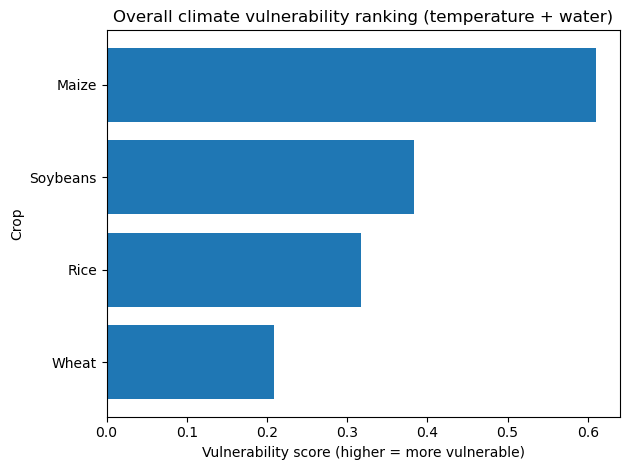

<Figure size 640x480 with 0 Axes>

In [28]:
# Figure 1: vulnerability ranking
plot_df = vuln_rank.sort_values("vuln_score", ascending=True)

plt.figure()
plt.barh(plot_df["crop"], plot_df["vuln_score"])
plt.xlabel("Vulnerability score (higher = more vulnerable)")
plt.ylabel("Crop")
plt.title("Overall climate vulnerability ranking (temperature + water)")
plt.tight_layout()
plt.show()

plt.savefig("fig2_vulnerability_ranking.png", dpi=300, bbox_inches="tight")

### Assessing vulnerability across income levels

We re-estimated crop-specific regressions separately for high-income versus non-high-income countries and compared climate coefficients across groups.

In [29]:
# High-income = "High income" vs. everything else (Low/Middle-income = everything else)

df_rq1_analysis["hi_income"] = (
    df_rq1_analysis["income_group"] == "High income"
).astype(int)

In [30]:
# running per-crop regression twice (HI vs non-HI)


def run_crop_reg(df, crop):
    d = df[df["crop_name"] == crop].copy()
    model = smf.ols(formula, data=d).fit(cov_type="HC1")
    return model, len(d)


groups = {
    "High income": df_rq1_analysis[df_rq1_analysis["hi_income"] == 1],
    "Non-high income": df_rq1_analysis[df_rq1_analysis["hi_income"] == 0],
}

In [31]:
# climate variables to compare across income groups
climate_vars = [
    "temperature_mean_yr",
    "temp_sd_daily_mean_yr",
    "extreme_temp_days_yr",
    "precipitation_yr",
    "precipitation_sd_yr",
    "water_deficit_yr",
]

results = []

for gname, gdf in groups.items():
    crops = sorted(gdf["crop_name"].unique())
    for c in crops:
        m, n = run_crop_reg(gdf, c)

        for var in climate_vars:
            results.append(
                {
                    "group": gname,
                    "crop": c,
                    "n": n,
                    "variable": var,
                    "coef": m.params.get(var, np.nan),
                    "se_robust": m.bse.get(var, np.nan),
                    "pvalue": m.pvalues.get(var, np.nan),
                    "r2": m.rsquared,
                }
            )

rq1_income_coef = pd.DataFrame(results)
rq1_income_coef

,group,crop,n,variable,coef,se_robust,pvalue,r2
0,High income,Maize,66,temperature_mean_yr,0.122109,0.071344,0.086981,0.307681
1,High income,Maize,66,temp_sd_daily_mean_yr,0.051934,0.075540,0.491765,0.307681
2,High income,Maize,66,extreme_temp_days_yr,-0.001692,0.002285,0.458923,0.307681
3,High income,Maize,66,precipitation_yr,-0.000679,0.000926,0.463680,0.307681
4,High income,Maize,66,precipitation_sd_yr,-0.005753,0.032580,0.859844,0.307681
5,High income,Maize,66,water_deficit_yr,-0.000618,0.000771,0.422821,0.307681
6,High income,Rice,41,temperature_mean_yr,0.021842,0.105257,0.835614,0.591825
7,High income,Rice,41,temp_sd_daily_mean_yr,-0.041982,0.098258,0.669190,0.591825
8,High income,Rice,41,extreme_temp_days_yr,0.000464,0.003504,0.894664,0.591825
9,High income,Rice,41,precipitation_yr,-0.000055,0.000934,0.953164,0.591825


In [32]:
# within high-income countries, which crop is most negatively affected by extreme heat?

most_negative = (
    rq1_income_coef.sort_values(["group", "variable", "coef"])  # most negative first
    .groupby(["group", "variable"])
    .head(1)[["group", "variable", "crop", "coef", "pvalue", "n"]]
)

most_negative

,group,variable,crop,coef,pvalue,n
14,High income,extreme_temp_days_yr,Soybeans,-0.003590,0.192683,68
4,High income,precipitation_sd_yr,Maize,-0.005753,0.859844,66
15,High income,precipitation_yr,Soybeans,-0.000817,0.224438,68
7,High income,temp_sd_daily_mean_yr,Rice,-0.041982,0.669190,41
18,High income,temperature_mean_yr,Wheat,-0.038159,0.545773,66
5,High income,water_deficit_yr,Maize,-0.000618,0.422821,66
26,Non-high income,extreme_temp_days_yr,Maize,-0.002128,0.121023,216
40,Non-high income,precipitation_sd_yr,Soybeans,-0.025543,0.080888,147
33,Non-high income,precipitation_yr,Rice,-0.000024,0.909566,197
31,Non-high income,temp_sd_daily_mean_yr,Rice,-0.036827,0.194527,197


In [33]:
# comparing extreme heat (low income vs. high income)

extreme_compare = rq1_income_coef[
    rq1_income_coef["variable"] == "extreme_temp_days_yr"
].pivot_table(
    index=["crop"], columns="group", values=["coef", "pvalue"], aggfunc="first"
)

extreme_compare

coef                      pvalue                
group    High income Non-high income High income Non-high income
crop                                                            
Maize      -0.001692       -0.002128    0.458923        0.121023
Rice        0.000464        0.002350    0.894664        0.001106
Soybeans   -0.003590       -0.001649    0.192683        0.215969
Wheat      -0.002523       -0.001471    0.308891        0.194580

By crop, rice stands out: extreme heat is estimated to increase yields in both income groups, but only the non-high-income estimate is statistically significant (p≈0.001). Maize shows a small negative extreme-heat association in both groups (slightly more negative in non-high-income), while soybeans and wheat also show negative coefficients in both groups, with no strong evidence of a clear high- vs. non-high-income split.

In [34]:
# high vs. low income (side by side) results

wide = rq1_income_coef.pivot_table(
    index=["crop", "variable"], columns="group", values="coef", aggfunc="first"
).reset_index()

# adjust the column names here if your group labels differ slightly
wide["diff_HI_minus_nonHI"] = wide["High income"] - wide["Non-high income"]
wide.sort_values(["variable", "diff_HI_minus_nonHI"])

group,crop,variable,High income,Non-high income,diff_HI_minus_nonHI
12,Soybeans,extreme_temp_days_yr,-0.003590,-0.001649,-0.001942
6,Rice,extreme_temp_days_yr,0.000464,0.002350,-0.001886
18,Wheat,extreme_temp_days_yr,-0.002523,-0.001471,-0.001052
0,Maize,extreme_temp_days_yr,-0.001692,-0.002128,0.000436
1,Maize,precipitation_sd_yr,-0.005753,0.015355,-0.021108
7,Rice,precipitation_sd_yr,0.004481,-0.011588,0.016070
13,Soybeans,precipitation_sd_yr,0.009822,-0.025543,0.035365
19,Wheat,precipitation_sd_yr,0.026753,-0.011814,0.038566
14,Soybeans,precipitation_yr,-0.000817,0.000526,-0.001343
2,Maize,precipitation_yr,-0.000679,0.000142,-0.000821


Overall, income-group heterogeneity is modest for extreme heat and water deficit (coefficients are similar across groups), but much stronger for precipitation variability and especially mean temperature, where several crops exhibit sign reversals between high-income and non-high-income estimates.

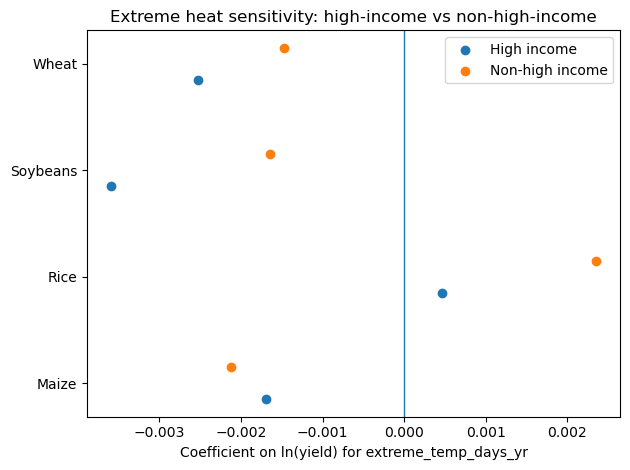

<Figure size 640x480 with 0 Axes>

In [35]:
# Figure 3: income comparison for extreme heat
ec = extreme_compare.copy()

# pulling out the two coefficient series
hi = ec[("coef", "High income")]
nonhi = ec[("coef", "Non-high income")]

crops = ec.index.astype(str)
y = np.arange(len(crops))
offset = 0.15

plt.figure()
plt.scatter(hi.values, y - offset, label="High income")
plt.scatter(nonhi.values, y + offset, label="Non-high income")
plt.axvline(0, linewidth=1)

plt.yticks(y, crops)
plt.xlabel("Coefficient on ln(yield) for extreme_temp_days_yr")
plt.title("Extreme heat sensitivity: high-income vs non-high-income")
plt.legend()
plt.tight_layout()
plt.show()

plt.savefig("fig3_income_diff.png", dpi=300, bbox_inches="tight")

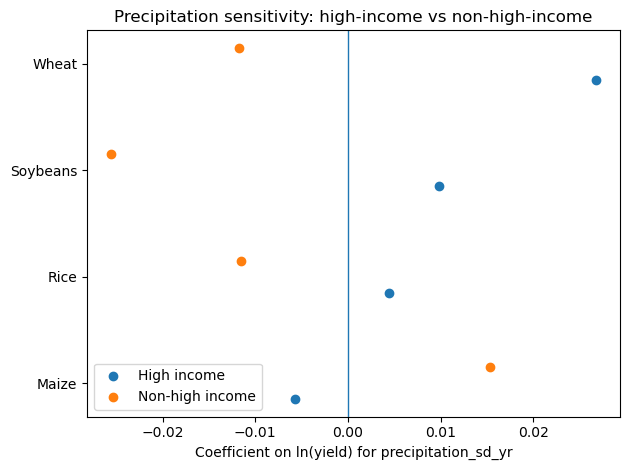

<Figure size 640x480 with 0 Axes>

In [36]:
# plotting income comparison for preciciptaiton variability

precip_compare = rq1_income_coef[
    rq1_income_coef["variable"] == "precipitation_sd_yr"
].pivot_table(index="crop", columns="group", values=["coef", "pvalue"], aggfunc="first")

# Figure 4: income comparison for precipitation (swap variable name in labels/title)

pc = precip_compare.copy()

hi = pc[("coef", "High income")]
nonhi = pc[("coef", "Non-high income")]

crops = pc.index.astype(str)
y = np.arange(len(crops))
offset = 0.15

plt.figure()
plt.scatter(hi.values, y - offset, label="High income")
plt.scatter(nonhi.values, y + offset, label="Non-high income")
plt.axvline(0, linewidth=1)

plt.yticks(y, crops)

# choose label/title that matches what you used above
plt.xlabel("Coefficient on ln(yield) for precipitation_sd_yr")  # or precipitation_yr
plt.title(
    "Precipitation sensitivity: high-income vs non-high-income"
)  # adjust text if SD
plt.legend()
plt.tight_layout()
plt.show()

plt.savefig("fig4_income_precip.png", dpi=300, bbox_inches="tight")